In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import time
import nfl_model
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

In [3]:
csv_data_path = '..\Data\playbyplaydata\*.csv'
X_train, X_test, y_train, y_test = nfl_model.gather_and_process_data(csv_data_path, test_season=None)

print('X_train: {}'.format(len(X_train)))
print('y_train: {}'.format(len(y_train)))
print('')
print('X_test : {}'.format(len(X_test)))
print('y_test : {}'.format(len(y_test)))
print('')
print('X_Total: {}'.format(len(X_train)+len(X_test)))
print('y_Total: {}'.format(len(y_test)+len(y_train)))



X_train: 195926
y_train: 195926

X_test : 96501
y_test : 96501

X_Total: 292427
y_Total: 292427


# Building a Random Forest Classification Model for NFL Decisions

## Game Time Decisions
Its 1st and Goal with less than a minute on the clock in the 4th quarter. Your team is down by 3 points, what do you do? Should you run the ball hoping to break into the endzone? What about passing the ball instead? Or should you go for the field goal just to get the tie. Everyone has an opinion on various NFL scenarios but we will build a model that tells you which decision the pros would make given the same situation.


### Data
To build our predictive model we first need some data. The NFL has released play by play information for every game since 2009. We can look at the features of each play to predict what the ultimate play decision was. Given that a play can have many different intended outcomes we will need to build a supervised classification model. 

### Inputs
From the NFL play-by-play data we can use the following info from each play as inputs to our RF model.
* Quarter 
* Time Remaining
* Down
* Yards to 1st Down
* Field Position
* Score

### Output
The RF model will be able to return a probability estimation for what the best decision would be for a given set of inputs (NFL situation). The possible play types would be the following:
* Pass
* Run
* Punt
* Field Goal
* QB Kneel

### Disclamer!
This model is designed to favor the "average" NFL decision for a given situation. It does not look to see if this decision will result in a positive outcome however since all historical decisions by NFL teams are made under the desire for a positive outcome so the model should reflect that desire as well. Stronger models utilizing more features of the data that indicate play success or failure could be built from the same dataset.

## Train/Test Data
For this model we will split our data into train and test data by season. The model will train using data from the 2009-2015 seasons and then will be tested on the 2016 season.

## Random Forest Model Tuning
  
#### Min_samples_leaf
Lets tune the *min_samples_leaf* parameter.  

We expect the smaller values to take more time since it means we are allowing the trees to terminate only once 'x' samples remain in a leaf's data subset. It will take more splits and decisions to make leaves with samples of 1 vs 300. It may also lead to overfitting at lower values since more decisions are being forced in each tree on smaller subsets of data. If the value is too large the model will build much quicker but it will not have made enough decisions in it's trees to get a deep enough look into the data and ultimately will miss some key indicators.

We will build and test the model for the following parameters and then plot each one's score to see it's impact on model performance:  
*[1,3,6,9,12,15,18,22,25,50,75,100,125,150,175,200,225,250,275,300]*



In [4]:
# Testing "min_samples_leaf"
min_samples_leaf = [1,3,6,9,12,15,18,22,25,50,75,100,125,150,175,200,225,250,275,300]
n_estimators = [30]

min_samples_leaf_scores = []
for n in n_estimators:
    print('-' * 40)
    for l in min_samples_leaf:
        print('--- Testing', '({},{})'.format(n,l))
        start = time.time()
        rfc = nfl_model.build_random_forest_model(
            X_train,
            y_train,
            n_estimators=n, 
            max_depth=None, 
            min_samples_split=2, 
            min_samples_leaf=l, 
            max_features='auto',  
            bootstrap=True, 
            oob_score=True, 
            n_jobs=-1, 
            random_state=0
        )
        stop = time.time()
        score = rfc.score(X_test, y_test)
        run_time = stop - start
        min_samples_leaf_scores.append([n, l, score, run_time])
        print('     Run Time: ', run_time)
        print('     Score:    ', score)

----------------------------------------
--- Testing (30,1)
     Run Time:  6.062781095504761
     Score:     0.673594567212
--- Testing (30,3)
     Run Time:  5.745964527130127
     Score:     0.695391440072
--- Testing (30,6)
     Run Time:  5.249364852905273
     Score:     0.701196637367
--- Testing (30,9)
     Run Time:  5.146740913391113
     Score:     0.704071853008
--- Testing (30,12)
     Run Time:  5.025480031967163
     Score:     0.705660067362
--- Testing (30,15)
     Run Time:  5.076037168502808
     Score:     0.705796982393
--- Testing (30,18)
     Run Time:  4.996846914291382
     Score:     0.703962320984
--- Testing (30,22)
     Run Time:  5.049829006195068
     Score:     0.707056600674
--- Testing (30,25)
     Run Time:  4.931021213531494
     Score:     0.707768558832
--- Testing (30,50)
     Run Time:  5.351311445236206
     Score:     0.708507899997
--- Testing (30,75)
     Run Time:  4.822534084320068
     Score:     0.708754347052
--- Testing (30,100)
     Ru

In [4]:
sns.set_context('talk')
sns.set_style('ticks')

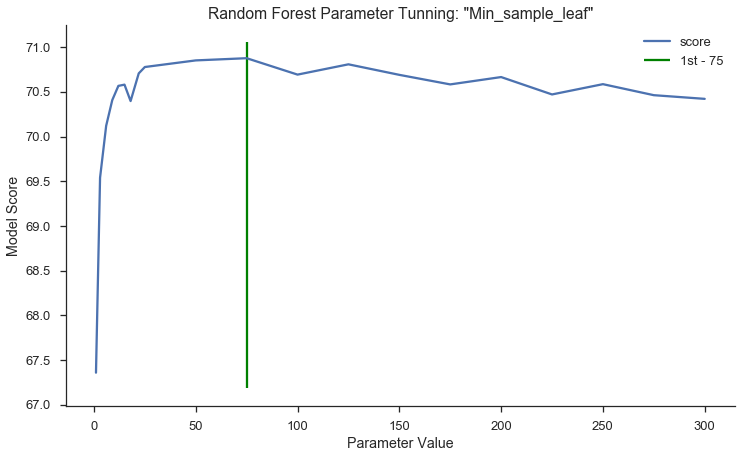

In [8]:
records = [{'n':x[0], 'l':x[1], 'score':x[2]*100, 'time':x[3]} for x in min_samples_leaf_scores]
results_df = pd.DataFrame.from_records(records)
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(results_df.l, results_df.score)
ax.set_title('Random Forest Parameter Tunning: "Min_sample_leaf"')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Model Score')
sns.despine()
ax.vlines(x=75,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='g', label='1st - 75')
ax.legend()
plt.show()


The testing shows the model performs poorly with "min_samples_leaf" values below 20 compared to values above 20.  
The highest tested mark occurs at a value of **75** which we will use in the final model.

#### N_estimators
Next up lets tune the *N_estimators* parameter.  

We expect the smaller values to take less time since we are requiring less trees to be made. The larger we can make this value the better however since more estimators is not going to hurt our model. More models do eventually take too much time/memory to easily compute. 

We will build and test the model for the following parameters and then plot each one's score to see it's impact on model performance:  
*[30,50,75,100,125,150,175,200,250,300]*

In [7]:
# Testing "n_estimators"
min_samples_leaf = [75]
n_estimators = [30,50,75,100,125,150,175,200,250,300]

n_estimator_scores = []
for n in n_estimators:
    print('-' * 40)
    for l in min_samples_leaf:
        print('--- Testing', '({},{})'.format(n,l))
        start = time.time()
        rfc = nfl_model.build_random_forest_model(
            X_train,
            y_train,
            n_estimators=n, 
            max_depth=None, 
            min_samples_split=2, 
            min_samples_leaf=l, 
            max_features='auto',  
            bootstrap=True, 
            oob_score=True, 
            n_jobs=-1, 
            random_state=0
        )
        stop = time.time()
        score = rfc.score(X_test, y_test)
        run_time = stop - start
        n_estimator_scores.append([n, l, score, run_time])
        print('     Run Time: ', run_time)
        print('     Score:    ', score)

----------------------------------------
--- Testing (30,75)
     Run Time:  2.6102001667022705
     Score:     0.512212308681
----------------------------------------
--- Testing (50,75)


KeyboardInterrupt: 

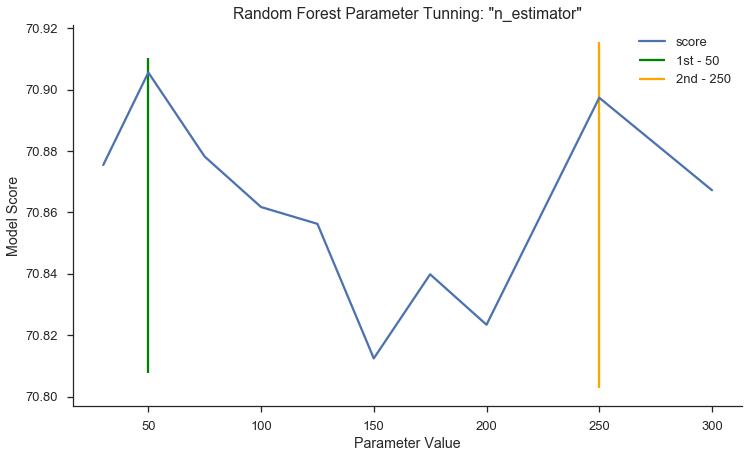

In [14]:
records = [{'n':x[0], 'l':x[1], 'score':x[2]*100, 'time':x[3]} for x in n_estimator_scores]
results_df = pd.DataFrame.from_records(records)
fig,ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(results_df.n, results_df.score)
ax.set_title('Random Forest Parameter Tunning: "n_estimator"')
ax.set_xlabel('Parameter Value')
ax.set_ylabel('Model Score')
sns.despine()
ax.vlines(x=50,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='green', label = '1st - 50')
ax.vlines(x=250,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1],colors='orange', label = '2nd - 250')
ax.legend()
plt.show()

Given the overall range of model score values to fall within 0.1 the number of estimators is not showing significant change to the model performance. A test was also done at 1000 estimators with a value in line with the above results. We will use a value of **250** n_estimators since the high score at 50 n_estimators could be a result of statistical randomness. The value of 250 strikes a good balance between computation time and statistical rigor.

In [5]:
winning_rfc = nfl_model.build_random_forest_model(
                X_train,
                y_train,
                n_estimators=250, 
                max_depth=None, 
                min_samples_split=2, 
                min_samples_leaf=75, 
                max_features='auto',  
                bootstrap=True, 
                oob_score=True, 
                n_jobs=-1, 
                random_state=0
            )

In [6]:
winning_rfc.score(X_test, y_test)

0.70901855939316694

# Using the model


### Model Score - 70.9%
After tuning our model we get a 2016 prediction score of **70.9%**. So nearly 3 out of 4 plays were predicted correctly. Based on this it would make good sense to return the probability estimates for each decision when using the model so you can see what the next closest decision was since it is likely that many of these situations have multiple outcomes that different teams tend to use more often than the next. Stronger models using more features can capitalize on this and build a more robust predictor given individual team/player information.

In [7]:
qtr = 4
down = 3
ydstogo = 10
TimeUnder = 1
yrdline100 = 40
ScoreDiff = 7

test_case = [[qtr, down, ydstogo, TimeUnder, yrdline100, ScoreDiff]]
classes = winning_rfc.classes_
rfcp = winning_rfc.predict_proba(test_case)[0]*100

rfcp = [str(round(x,2)) for x in rfcp]

print("")
print("Random Forest")
for item in zip(classes,rfcp):
    print(item)




Random Forest
('Field Goal', '1.6')
('Pass', '25.06')
('Punt', '1.03')
('QB Kneel', '40.9')
('Run', '31.42')


In [74]:
nfl_model.store_model(winning_rfc,'random_forest_classifier')

## Multiclass ROC and Precision-Recall

Understanding model class prediction performace

In [8]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
y_test_classes = {cls:[True if c == cls else False for c in y_test ] for cls in winning_rfc.classes_.tolist()}
rfc_result = winning_rfc.predict_proba(X_test)
rfc_classes = winning_rfc.classes_.tolist()
y_predicted_probs = {cls:[item[rfc_classes.index(cls)] for item in rfc_result] for cls in rfc_classes}

In [9]:
fpr = {cls:[] for cls in rfc_classes}
tpr = {cls:[] for cls in rfc_classes}

In [10]:
pre = {cls:[] for cls in rfc_classes}
rec = {cls:[] for cls in rfc_classes}

In [11]:
for cls in rfc_classes:
    data = roc_curve(y_test_classes[cls]*1,y_predicted_probs[cls])
    fpr[cls] = data[0]
    tpr[cls] = data[1]
    data = precision_recall_curve(y_test_classes[cls]*1, y_predicted_probs[cls])
    pre[cls] = data[0]
    rec[cls] = data[1]

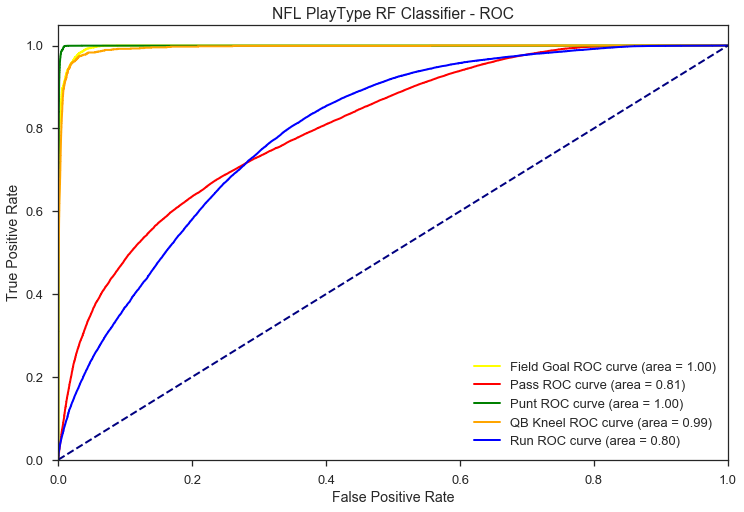

In [12]:
colors = {'Pass':'red', 'Run':'blue', 'Punt':'green', 'QB Kneel':'orange', 'Field Goal':'yellow'}
sns.set_context('talk')
plt.figure(figsize=(12,8))
lw = 2
for cls in rfc_classes:
    plt.plot(fpr[cls],tpr[cls], color=colors[cls],lw=lw,label=cls + ' ROC curve (area = %0.2f)' % auc(fpr[cls],tpr[cls]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NFL PlayType RF Classifier - ROC')
plt.legend(loc="lower right")
plt.savefig('ROC')
plt.show()

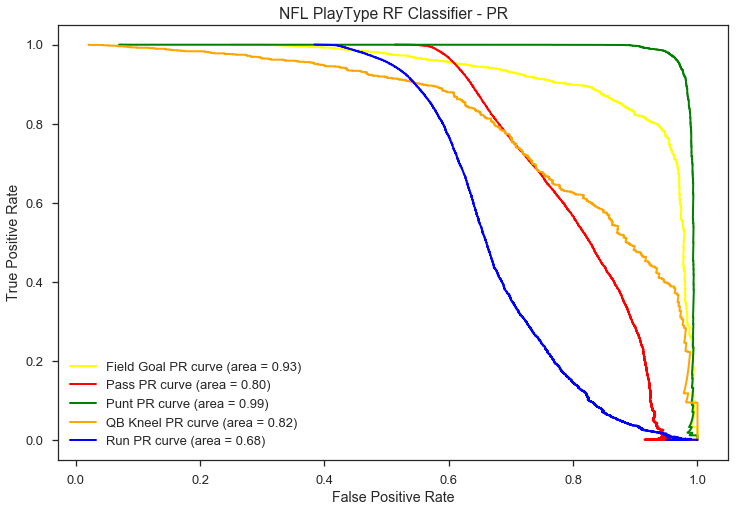

In [13]:
colors = {'Pass':'red', 'Run':'blue', 'Punt':'green', 'QB Kneel':'orange', 'Field Goal':'yellow'}
sns.set_context('talk')
plt.figure(figsize=(12,8))
lw = 2
for cls in rfc_classes:
    plt.plot(pre[cls],rec[cls], color=colors[cls],lw=lw,label=cls + ' PR curve (area = %0.2f)' % auc(rec[cls],pre[cls]))
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
#plt.xlim([0.0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('NFL PlayType RF Classifier - PR')
plt.legend(loc="lower left")
plt.show()

# Random Forest Hyperparameter Tuning Using GridSearchCV
It is typical to perform much more testing to get the hyper parameters optimized.

In [14]:
def build_random_forest_model(X_train, y_train, n_estimators=10,
    max_depth=None, min_samples_split=2, min_samples_leaf=1,
    max_features='auto', bootstrap=True, oob_score=False, n_jobs=1,
    random_state=None
    ):
    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        oob_score=oob_score,
        n_jobs=n_jobs,
        random_state=random_state
    )
    clf.fit(X_train, y_train)
    return clf

In [15]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [115]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=False, max_features='auto')
param_grid = {
    'n_estimators':[100,150,200,250,300,350,400],
    'min_samples_leaf':[25],
    'bootstrap':[True]
}
skf = StratifiedKFold(n_splits=2, random_state=42, shuffle=True)
grid_search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=skf.split(X_train, y_train), verbose=20)
grid_search.fit(X_train, y_train)
gs = grid_search
gsbp = grid_search.best_params_
print(grid_search.best_params_)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   36.3s
[Parallel(n_jobs=-1)]: Done   2 out of  14 | elapsed:   41.6s remaining:  4.2min
[Parallel(n_jobs=-1)]: Done   3 out of  14 | elapsed:   56.5s remaining:  3.5min
[Parallel(n_jobs=-1)]: Done   4 out of  14 | elapsed:   57.3s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of  14 | elapsed:  1.2min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done   6 out of  14 | elapsed:  1.2min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  14 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   8 out of  14 | elapsed:  1.5min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   9 out of  14 | elapsed:  2.1min remaining:  1.2min
[Parallel(n_jobs=-1)]: Done  10 out of  14 | elapsed:  2.2min remaining:   52.7s
[Parallel(n_jobs=-1)]: Done  11 out of  14 | elapsed:  2.4min remaining:   39.2s
[Parallel(n_jobs=-1)]: Done  12 out of  14 | elapsed:  2.4min remaining:   24.3s
[Parallel(n_jobs=-1)]: Done  14 out of  14 | el

{'bootstrap': True, 'min_samples_leaf': 25, 'n_estimators': 150}


In [52]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=25,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=25, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [110]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
skf.get_n_splits(X_train, y_train)
print(skf)
fold_number = 1
scores = []
for train_index, test_index in skf.split(X_train, y_train):
    train_index = train_index.tolist()
    test_index = test_index.tolist()
    print("TRAIN:", len(train_index), "TEST:", len(test_index))
    X_f, X_ft = X_train[train_index], X_train[test_index]
    y_f, y_ft = y_train[train_index], y_train[test_index]
    print('--- Fold {} ---'.format(fold_number))
    print('    Training...')
    start = time.time()
    rfc = nfl_model.build_random_forest_model(
        X_f,
        y_f,
        n_estimators=250, 
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=75,
        max_features='auto',
        bootstrap=True,
        oob_score=True,
        n_jobs=-1,
        random_state=0
    )
    stop = time.time()
    print('    Scoring...')
    score = rfc.score(X_ft, y_ft)
    scores.append(score)
    run_time = stop - start
    print('    Run Time: ', run_time)
    print('    Score:    ', score)
    fold_number += 1
print('')
print('Avergae Score: {}'.format(np.mean(scores)))

StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
TRAIN: 176331 TEST: 19595
--- Fold 1 ---
    Training...
    Scoring...
    Run Time:  25.342599391937256
    Score:     0.709517734116
TRAIN: 176331 TEST: 19595
--- Fold 2 ---
    Training...
    Scoring...
    Run Time:  25.61939549446106
    Score:     0.706863995917
TRAIN: 176331 TEST: 19595
--- Fold 3 ---
    Training...
    Scoring...
    Run Time:  26.119253635406494
    Score:     0.704108190865
TRAIN: 176333 TEST: 19593
--- Fold 4 ---
    Training...
    Scoring...
    Run Time:  25.306822538375854
    Score:     0.70892665748
TRAIN: 176334 TEST: 19592
--- Fold 5 ---
    Training...
    Scoring...
    Run Time:  25.39920473098755
    Score:     0.70641077991
TRAIN: 176334 TEST: 19592
--- Fold 6 ---
    Training...
    Scoring...
    Run Time:  25.712658643722534
    Score:     0.70641077991
TRAIN: 176334 TEST: 19592
--- Fold 7 ---
    Training...
    Scoring...
    Run Time:  25.89996337890625
    Score:     0.7139648